In [2]:
from rtlsdr import RtlSdr
import pylab

# NOTE(dominic): This is super lame, but iptyhon kernels are running in the directory they are
# contained. That means, we cannot access any other sub-modules from within these notebooks.
# We resolve this by temporarily adding the parent directory to the path.

import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from util.plotting import compute_fft_plot, compute_fft_plot_from_sample_rate, compute_frequency_response
from util.filtering import compute_lpf_coeff, filter_complex_signal, filter_real_signal
from util.data_io import read_sdriq_data
from util.demodulation import demodulate_signal, chunked_demodulate_signal

import numpy as np
from scipy.io import wavfile

loaded raw signal of length 230400064
Signal min: 25.504902
Signal mean: 84.17035
Signal max: 149.20624


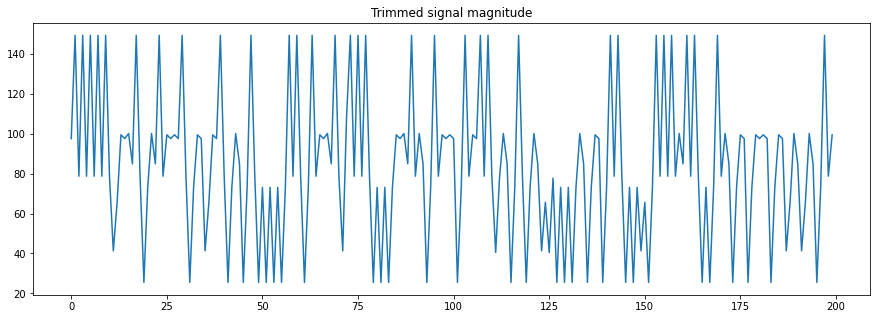

In [3]:
signal = read_sdriq_data("/Users/benjaminpattison/Documents/Projects/satNav/SDR_satellite_tracking/data/gqrx_20211121_204702_435103000_1920000_fc_cropped.raw")
center_frequency = 435103000
sample_frequency = 1920000
trimmed_signal = signal[169:int(169+1*sample_frequency/9600)]

print("Signal min:", np.min(np.abs(trimmed_signal)))
print("Signal mean:", np.mean(np.abs(trimmed_signal)))
print("Signal max:", np.max(np.abs(trimmed_signal)))

pylab.figure(1,figsize=(15,5))
pylab.plot(np.abs(trimmed_signal))
pylab.title("Trimmed signal magnitude")
pylab.show(1)

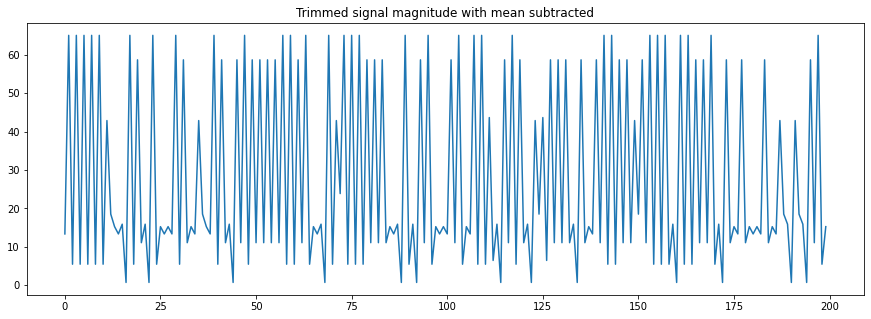

In [4]:
trimmed_signal_no_mean = np.abs(trimmed_signal) - np.mean(np.abs(trimmed_signal))
pylab.figure(2,figsize=(15,5))
pylab.plot(np.abs(trimmed_signal_no_mean))
pylab.title("Trimmed signal magnitude with mean subtracted")
pylab.show(2)

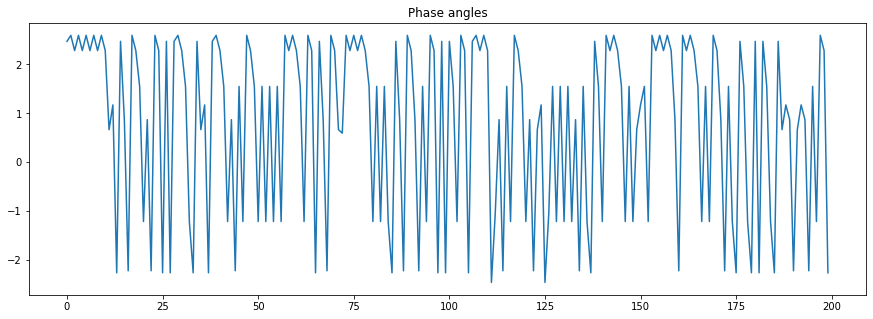

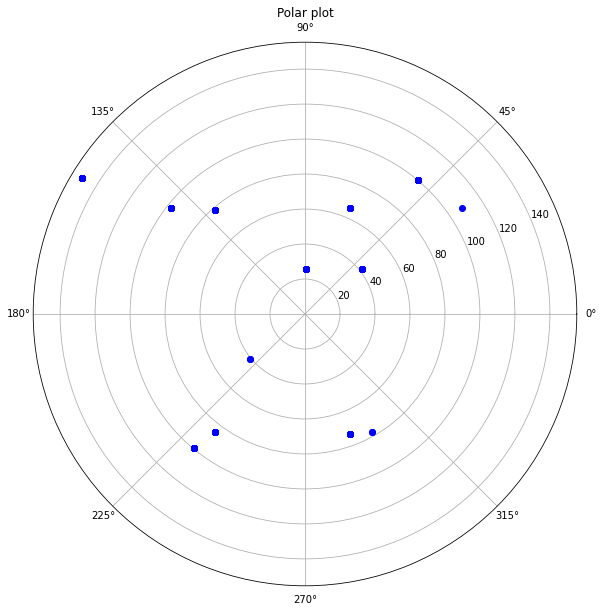

In [5]:
phase_angles = np.angle(trimmed_signal)

pylab.figure(3,figsize=[15,5])
pylab.plot(phase_angles)
pylab.title("Phase angles")
pylab.show(3)

pylab.figure(4,figsize=(10,10))
pylab.polar(phase_angles,np.abs(trimmed_signal),'bo')
pylab.title("Polar plot")
pylab.show()


Min angle: -2.4610715
Max angle: 2.595426


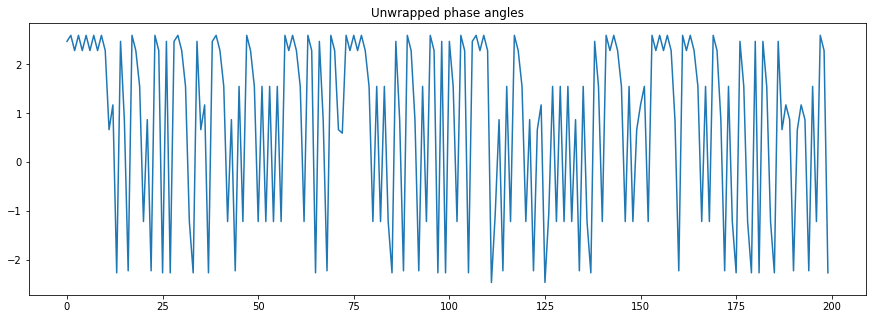

In [6]:
unwrapped_phase_angles = np.unwrap(phase_angles,discont=(np.max(phase_angles)-np.min(phase_angles)))
print("Min angle:", np.min(phase_angles))
print("Max angle:", np.max(phase_angles))

pylab.figure(5,figsize=[15,5])
pylab.plot(unwrapped_phase_angles)
pylab.title("Unwrapped phase angles")
pylab.show(5)

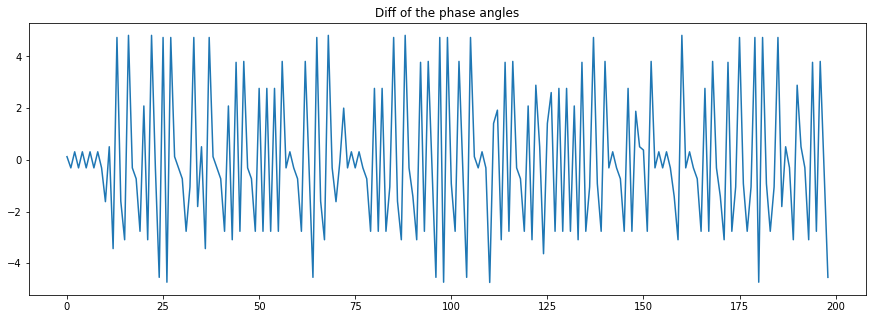

In [7]:
phase_angle_diff = np.diff(phase_angles)

pylab.figure(4,figsize=[15,5])
pylab.plot(phase_angle_diff)
pylab.title("Diff of the phase angles")
pylab.show(4)

[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 0.]


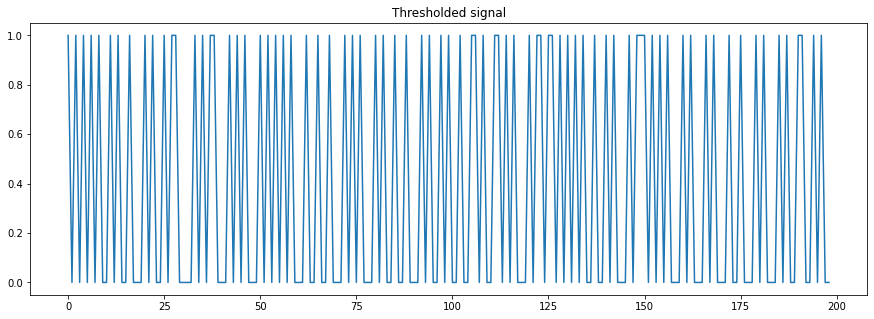

In [8]:
threshold_signal = np.empty(phase_angle_diff.shape[0])
threshold_signal[phase_angle_diff<0] = 0
threshold_signal[phase_angle_diff>0] = 1

print(threshold_signal)

pylab.figure(5,figsize=[15,5])
pylab.plot(threshold_signal)
pylab.title("Thresholded signal")
pylab.show(5)

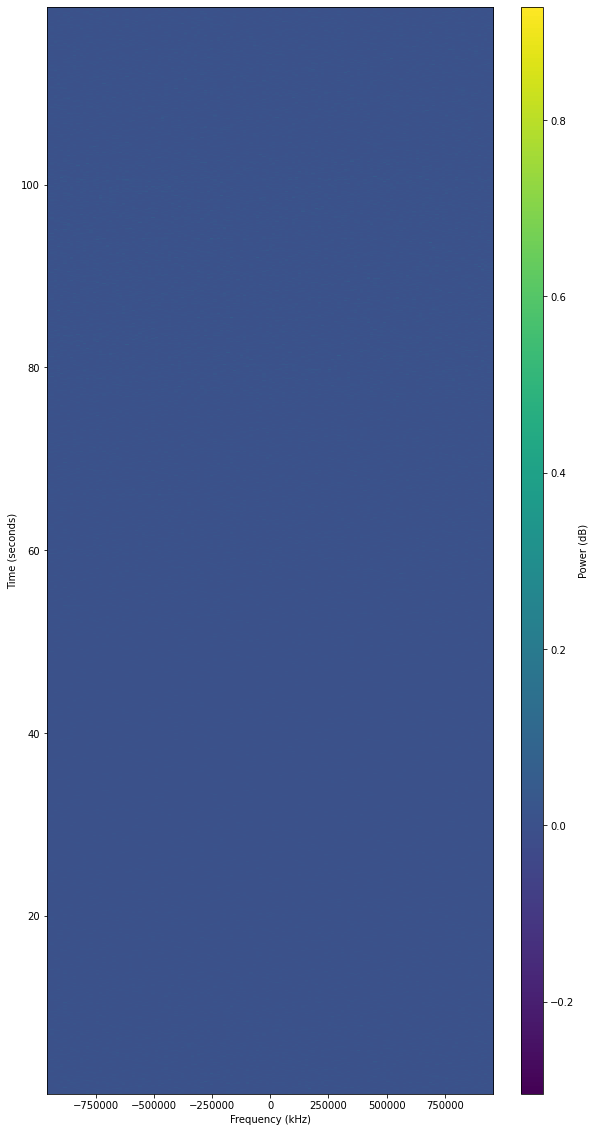

In [11]:
import scipy.signal
from scipy.fft import fftshift
window_param = scipy.signal.get_window("hamming",int(1.92e6))
f,t,Sxx = scipy.signal.spectrogram(signal,fs=1.92e6,window=window_param)

# Get spectra
spec=Sxx

# Get extrema
fmin,fmax=np.min(f),np.max(f)
tmin,tmax=np.min(t),np.max(t)
"""
# Set dynamic range
c=spec>-200.0
if np.sum(c)>100:
    vmin=np.mean(spec[c])-2.0*np.std(spec[c])
    vmax=np.mean(spec[c])+6.0*np.std(spec[c])
else:
    vmin=-100
    vmax=-50
"""
cmap="viridis"
#print("%s %.2f %.2f %.2f %.2f %.2f"%(fname,np.mean(spec[c]),np.median(spec[c]),np.std(spec[c]),vmin,vmax))

# Make plot
pylab.figure(figsize=(10,20))
pylab.imshow(spec,origin='lower',aspect='auto',interpolation='None',extent=[fmin,fmax,tmin,tmax],vmin=vmin,vmax=vmax,cmap=cmap)
pylab.xlabel("Frequency (kHz)")
pylab.ylabel("Time (seconds)")
fig=pylab.colorbar(aspect=50)
fig.set_label("Power (dB)")
pylab.show()

In [ ]:
print(Sxx.shape)
print(f.shape)
print(t.shape)
print(signal.shape[0]/1.92e6)

(1920000, 137)
(1920000,)
(137,)
120.00003333333333


In [ ]:
pylab.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
pylab.ylabel('Frequency [Hz]')
pylab.xlabel('Time [sec]')
pylab.show()

In [ ]:
pylab.imshow(Sxx,cmap)